In [1]:
"""
@Title:
    Solving Helmholtz equation with PDDO-PINNs.
    该代码用于准备网络输入所需要的数据，
    I.  PDDO系数和周边算子分布的四维array保存在.pickle，
    II. 声场计算程序ram仿真结果和其他环境参数保存在.mat中，
    III.日志文件保存在为log.txt
@author:
    Xu Liang.
    Department of Underwater Acoustic,
    Harbin Engineering University.
    2013053118@hrbeu.edu.cn
Created on 2021
"""
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from itertools import product, combinations
from sciann_datagenerator import DataGeneratorXYT
import pickle
import tqdm
from time import sleep
import os

In [2]:
def axisEqual3D(axx, nn):
    extents = np.array([getattr(axx, 'get_{}lim'.format(dim))() for dim in 'xyz'])
    sz = extents[:, 1] - extents[:, 0]
    centers = np.mean(extents, axis=1)
    maxsize = max(abs(sz))
    r = maxsize / nn
    for ctr, dim in zip(centers, 'xyz'):
        getattr(axx, 'set_{}lim'.format(dim))(ctr - r, ctr + r)

In [3]:
if __name__ == "__main__":
    print('本程序生成基于PINNs抛物近似所需数据集~')
    print('程序开始！一定不要出错呀！（＞﹏＜）')
    current_path = os.path.abspath('')
    par_filepath = str(os.path.join(current_path, 'Data/bin/parameters.txt'))
    rep_filepath = str(os.path.join(current_path, 'Data/bin/real.grid'))
    img_filepath = str(os.path.join(current_path, 'Data/bin/imag.grid'))
    ssp_filepath = str(os.path.join(current_path, 'Data/bin/ssp.grid'))
    rho_filepath = str(os.path.join(current_path, 'Data/bin/rho.grid'))

    # parameters
    par = np.loadtxt(par_filepath)
    omega = par[0]
    Range_max = par[1]
    dr = par[2]
    nr = int(Range_max / dr)
    nz = int(par[3]) + 2
    dz = par[4]
    iz = int(par[3])
    # nz = int(par[5])
    eps = 1e-20
    with open(rep_filepath, mode="rb") as f1:
        temp = np.fromfile(f1, dtype=np.float32)
        Re_P_data = np.reshape(temp, [nr, nz])
        f1.close()

    with open(img_filepath, mode="rb") as f2:
        temp = np.fromfile(f2, dtype=np.float32)
        Im_P_data = np.reshape(temp, [nr, nz])
        f2.close()

    with open(ssp_filepath, mode="rb") as f3:
        temp = np.fromfile(f3, dtype=np.float32)
        SSP_data = np.reshape(temp, [nr, nz])
        f3.close()

    with open(rho_filepath, mode="rb") as f4:
        temp = np.fromfile(f4, dtype=np.float32)
        Rho_data = np.reshape(temp, [nr, nz])
        f4.close()

    SSP_star = SSP_data[:, 1:-1]  # R x Z
    omega = omega * np.ones(SSP_star.shape)
    K_star = omega / SSP_star

    R_star = np.arange(dr, Range_max + dr, dr)
    Z_star = np.arange(dz, (iz+1) * dz, dz, dtype=int)

    R = R_star.shape[0]  # R
    Z = Z_star.shape[0]  # Z

    # Rearrange Data
    Re_P_star = Re_P_data[:, 1:nz-1]  # R x Z
    Im_P_star = Im_P_data[:, 1:nz-1]  # R x Z
    rloss = np.tile(10 * np.log10(R_star), (Z, 1)).T
    TL = -20 * np.log10(eps + np.sqrt(Re_P_star ** 2 + Im_P_star ** 2)) + rloss
    # Family cell
    ru = 1.1
    rd = 2.0
    zu = 30.0
    zd = 60.0

    box_lb = np.array([ru, zu])
    box_ub = np.array([rd, zd])
    # sample
    dg = DataGeneratorXYT(
        X=[R_star[0], R_star[-1]],
        Y=[Z_star[0], Z_star[-1]],
        T=[1450.0, 1550.0],
        targets=["domain"],
        num_sample=5000,
    )
    R_train = dg.input_data[0]
    Z_train = dg.input_data[1]
    C_train = dg.input_data[2]
    RR, ZZ = np.meshgrid(R_star, Z_star)
    # Plotting

本程序生成基于PINNs抛物近似所需数据集~
程序开始！一定不要出错呀！（＞﹏＜）


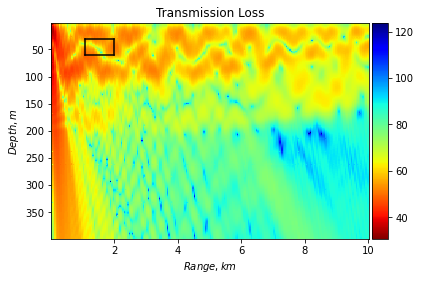

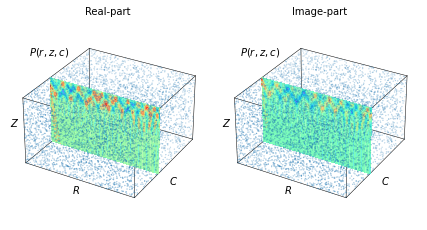

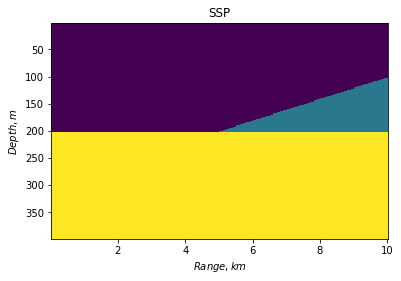

In [4]:
    # Row 0: Pressure
    fig = plt.figure(1)
    gs0 = gridspec.GridSpec(1, 2)
    gs0.update(top=1 - 0.1, bottom=0.15, left=0.12, right=.9, wspace=0)
    ax = plt.subplot(gs0[:, :])
    # ax = plt.subplot(2, 1, 1)
    h = ax.pcolormesh(RR / 1000, ZZ, TL.T, cmap='jet_r', shading='nearest')
    ax.invert_yaxis()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)

    ax.plot([box_lb[0], box_lb[0]], [box_lb[1], box_ub[1]], 'k', linewidth=1.5)
    ax.plot([box_ub[0], box_ub[0]], [box_lb[1], box_ub[1]], 'k', linewidth=1.5)
    ax.plot([box_lb[0], box_ub[0]], [box_lb[1], box_lb[1]], 'k', linewidth=1.5)
    ax.plot([box_lb[0], box_ub[0]], [box_ub[1], box_ub[1]], 'k', linewidth=1.5)

    ax.set_xlabel('$Range,km$')
    ax.set_ylabel('$Depth,m$')
    ax.set_title('Transmission Loss', fontsize=12)
    plt.savefig('./figures/fig5.png')

    n1 = 1e3  # R
    n2 = 10  # C
    n3 = .5e2  # Z
    n4 = 2.0
    fig2 = plt.figure(2)
    gs1 = gridspec.GridSpec(1, 2)
    gs1.update(top=0.8, bottom=0.1, left=0.01, right=0.99, wspace=0)
    ax = plt.subplot(gs1[:, 0], projection='3d')
    ax.axis('off')

    r1 = [R_train.min() / n1, R_train.max() / n1]
    r2 = [C_train.min() / n2, C_train.max() / n2]
    r3 = [Z_train.min() / n3, Z_train.max() / n3]

    for s, e in combinations(np.array(list(product(r1, r2, r3))), 2):
        if np.sum(np.abs(s - e)) == r1[1] - r1[0] or np.sum(np.abs(s - e)) == r2[1] - r2[0] or \
                np.sum(np.abs(s - e)) == r3[1] - r3[0]:
            ax.plot3D(*zip(s, e), color="k", linewidth=0.5)

    ax.scatter(R_train / n1, C_train / n2, Z_train / n3, s=0.05)
    ax.contourf(RR / n1, Re_P_star.T, np.flipud(ZZ) / n3, zdir='y', offset=C_train.mean() / n2, cmap='rainbow',
                alpha=0.8)
    ax.text(R_train.mean() / n1, C_train.min() / n2 - 1, Z_train.min() / n3 - 1, '$R$')
    ax.text(R_train.max() / n1 + 1, C_train.mean() / n2, Z_train.min() / n3 - 1, '$C$')
    ax.text(R_train.min() / n1 - 1, C_train.min() / n2 - 0.5, Z_train.mean() / n3, '$Z$')
    ax.text(R_train.min() / n1 - 2, C_train.mean() / n2, Z_train.max() / n3 + 2, '$P(r,z,c)$')
    ax.set_xlim3d(r1)  # R
    ax.set_ylim3d(r2)  # C
    ax.set_zlim3d(r3)  # Z
    axisEqual3D(ax, n4)
    ax.set_title('Real-part', fontsize=10)

    ax = plt.subplot(gs1[:, 1], projection='3d')
    ax.axis('off')
    r1 = [R_train.min() / n1, R_train.max() / n1]
    r2 = [C_train.min() / n2, C_train.max() / n2]
    r3 = [Z_train.min() / n3, Z_train.max() / n3]

    for s, e in combinations(np.array(list(product(r1, r2, r3))), 2):
        if np.sum(np.abs(s - e)) == r1[1] - r1[0] or np.sum(np.abs(s - e)) == r2[1] - r2[0] or \
                np.sum(np.abs(s - e)) == r3[1] - r3[0]:
            ax.plot3D(*zip(s, e), color="k", linewidth=0.5)

    ax.scatter(R_train / n1, C_train / n2, Z_train / n3, s=0.05)
    ax.contourf(RR / n1, Im_P_star.T, np.flipud(ZZ) / n3, zdir='y', offset=C_train.mean() / n2, cmap='rainbow',
                alpha=0.8)
    ax.text(R_train.mean() / n1, C_train.min() / n2 - 1, Z_train.min() / n3 - 1, '$R$')
    ax.text(R_train.max() / n1 + 1, C_train.mean() / n2, Z_train.min() / n3 - 1, '$C$')
    ax.text(R_train.min() / n1 - 1, C_train.min() / n2 - 0.5, Z_train.mean() / n3, '$Z$')
    ax.text(R_train.min() / n1 - 2, C_train.mean() / n2, Z_train.max() / n3 + 2, '$P(r,z,c)$')
    ax.set_xlim3d(r1)
    ax.set_ylim3d(r2)
    ax.set_zlim3d(r3)
    axisEqual3D(ax, n4)
    ax.set_title('Image-part', fontsize=10)
    plt.savefig('./figures/fig6.png')
    
    # Row 3: SSP
    fig = plt.figure(3)
    gs0 = gridspec.GridSpec(1, 2)
    gs0.update(top=1 - 0.1, bottom=0.15, left=0.12, right=.9, wspace=0)
    ax = plt.subplot(gs0[:, :])
    h = ax.pcolormesh(RR / 1000, ZZ, SSP_data[:, 1:-1].T, shading='nearest')
    ax.invert_yaxis()
    ax.set_xlabel('$Range,km$')
    ax.set_ylabel('$Depth,m$')
    ax.set_title('SSP', fontsize=12)
    plt.savefig('./figures/fig5-4.png')
    

In [5]:
    # output2mat
    print('.mat写入ing...')
    Re_Pa_star = Re_P_star[0:-1, :].T
    Re_Pb_star = Re_P_star[1:, :].T
    Im_Pa_star = Im_P_star[0:-1, :].T
    Im_Pb_star = Im_P_star[1:, :].T
    c_star = SSP_data.T[:, :]
    ca_star = c_star[1:-1, 0:-1]
    cb_star = c_star[1:-1, 1:]
    rho_star = Rho_data.T[:, :]
    rhoa_star = rho_star[0:-1, :]
    rhob_star = rho_star[1:, :]
    omega_star = omega.T[:, 1:]
    scipy.io.savemat('Data/slit_cylinder_pre_c0_w0.mat', {
        'RePa_star': Re_Pa_star,
        'RePb_star': Re_Pb_star,
        'ImPa_star': Im_Pa_star,
        'ImPb_star': Im_Pb_star,
        'ca_star': ca_star,
        'cb_star': cb_star,
        'rhoa_star': rhoa_star,
        'rhob_star': rhob_star,
        'R': R_star,
        'Z': Z_star,
        'omega_star': omega_star,
        'c0': 1500.0,
        'Versions': 'ramgeo1.5'
    })
    print('Origin Matric Size:')
    print('Re_P_star:', Re_P_star.shape)
    print('Im_P_star:', Im_P_star.shape)
    print('Slit Matric Size:')
    print('Re_Pa_star:', Re_Pa_star.shape)
    print('Re_Pb_star:', Re_Pb_star.shape)
    print('Im_Pa_star:', Im_Pa_star.shape)
    print('Im_Pb_star:', Im_Pb_star.shape)
    print('ca_star:', ca_star.shape)
    print('cb_star:', cb_star.shape)
    print('omega_star:', omega_star.shape)
    print('完结撒花！')

.mat写入ing...
Origin Matric Size:
Re_P_star: (200, 199)
Im_P_star: (200, 199)
Slit Matric Size:
Re_Pa_star: (199, 199)
Re_Pb_star: (199, 199)
Im_Pa_star: (199, 199)
Im_Pb_star: (199, 199)
ca_star: (199, 199)
cb_star: (199, 199)
omega_star: (199, 199)
完结撒花！
